# Sequential Quadratic Programming

## Quadratic Programming

An optimization problem with a quadratic objective function and linear
constraints is called a _quadratic program_. Problems of this
type are important in their own right, and they also arise a subproblems
in methods for general constrained optimization such as sequential
quadratic programming (this chapter) and interior-point methods (lecture 10).

The general quadratic program can be stated as

\begin{align*}
\min_{\vec{x}}\, & f\left(\vec{x}\right)\overset{\vartriangle}{=}\frac{1}{2}\vec{x}^\mathsf{T}Q\vec{x}-\vec{c}^\mathsf{T}\vec{x}\\
\textrm{subject to}\, & \begin{cases}
A_{\textrm{eq}}\vec{x}=\vec{b}_{\textrm{eq}}\,,\\
A_{\textrm{in}}\vec{x}\leq\vec{b}_{\textrm{in}}\,,
\end{cases}
\end{align*}

where $Q$ is a symmetric $n\times n$ matrix, $\vec{c}\in\mathbb R^{n}$,
$A_{\textrm{eq}}$ is a $m\times n$ matrix, $\vec{b}_{\textrm{eq}}\in\mathbb R^{m}$,
$A_{\textrm{in}}$ is a $p\times n$ matrix and $\vec{b}_{\textrm{in}}\in\mathbb R^{p}$.
If the Hessian matrix $Q$ is positive semidefinite, we have a convex
quadratic program. Non-convex quadratic programs, in which $Q$ is
an indefinite matrix, can be more challenging because they have several
stationary points and local minima.

## Equality Constraints

We begin our discussion of algorithms for quadratic programming by considering
the case in which only equality constraints are present. We consider
to following equality-constrained quadratic problem
\begin{align}
\min_{\vec{x}}\, & f\left(\vec{x}\right)\overset{\vartriangle}{=}\frac{1}{2} \vec{x}^\mathsf{T}Q\vec{x}- \vec{c}^\mathsf{T}\vec{x}\\
\textrm{subject to}\, & A\vec{x}=\vec{b}\,,\nonumber 
\end{align}
where $A$ is the $m\times n$ Jacobian of constraints and $\vec{b}\in\mathbb R^{m}$.
We assume that $A$ has rank $m$ so that the constraints are consistent.

The First Order Necessary Condition (FONC) uses the Langrangian function
\begin{equation}
\mathcal L\left(\vec x, \vec \lambda\right)=\vec{x}^\mathsf{T}Q\vec{x}- \vec{c}^\mathsf{T}\vec{x} + \vec\lambda^\mathsf{T} \left(A\vec{x}-\vec{b}\right)
\end{equation}
and gives the following condition
\begin{align}
\nabla_{\vec x}\mathcal L\left(\vec x ^\star, \vec \lambda ^\star\right)&=\vec 0\,,\\
\nabla_{\vec \lambda}\mathcal L\left(\vec x ^\star, \vec \lambda ^\star\right)&=\vec 0\,,
\end{align}
So the FONC for $\vec{x}^{\star}$ to be a solution of the quadratic
problem yields a vector $\vec{\lambda}^{\star}$ such
that the following system of equations is satisfied:
\begin{equation}
\begin{pmatrix}Q & A^\mathsf{T}\\
A & 0
\end{pmatrix}\begin{pmatrix}\vec{x}^{\star}\\
\vec{\lambda}^{\star}
\end{pmatrix}=\begin{pmatrix}\vec{c}\\
\vec{b}
\end{pmatrix}\,.\label{eq:equality_constraint}
\end{equation}
This system can be solved directly by factorization. An alternative
is to use an iterative method.

Consider the quadratic programming problem
\begin{align*}
\min_{\vec{x}}\, & \frac{1}{2} \vec{x}^\mathsf{T}\begin{pmatrix}6 & 2 & 1\\
2 & 5 & 2\\
1 & 2 & 4
\end{pmatrix}\vec{x}- \begin{pmatrix}8\\
3\\
3
\end{pmatrix}^\mathsf{T}\vec{x}\\
\textrm{subject to}\, & \begin{pmatrix}1 & 0 & 1\\
0 & 1 & 1
\end{pmatrix}\vec{x}=\begin{pmatrix}3\\
0
\end{pmatrix}\,.
\end{align*}

In [50]:
Q = [6 2 1
     2 5 2
     1 2 4]
c = [8, 3, 3]
A = [1 0 1
     0 1 1]
b = [3, 0]
sol = [Q transpose(A)
       A zeros(2,2)] \ [c; b]

5-element Array{Float64,1}:
  2.0               
 -1.0               
  1.0               
 -3.0               
  1.9999999999999996

The solution $\vec{x}^{\star}$ and optimal Lagrange multiplier vector $\vec \lambda^\star$ are given by
\begin{align*}
\vec{x}^{\star} & = \begin{pmatrix}2 & -1 & 1\end{pmatrix}^\mathsf{T}\,,\\
\vec{\lambda}^{\star} & = \begin{pmatrix}3 & -2\end{pmatrix}^\mathsf{T}\,.
\end{align*}

## Active Set Method

We now describe active-set methods for solving quadratic programs
containing both equality and inequality constraints. We consider only
the convex case, in which the matrix $Q$ is positive semidefinite.

If the contents of the optimal active set $J\left(\vec x^\star\right)$ were known in advance, we could find the solution $\vec{x}^{\star}$
by applying the technique for equality constrained quadratic programs
to the problem
\begin{align*}
\min_{\vec{x}}\, & f\left(\vec{x}\right)\overset{\vartriangle}{=}\frac{1}{2} \vec{x}^\mathsf{T}Q\vec{x}- \vec{c}^\mathsf{T}\vec{x}\\
\textrm{subject to}\, & \begin{cases}
A_{\textrm{eq}}\vec{x}=\vec{b}_{\textrm{eq}}\,,\\
 \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{x}=b_{\textrm{in},j}\,, & \forall j\in J\left(\vec{x}^{\star}\right)\,,
\end{cases}
\end{align*}
where $\vec{a}_{\textrm{in},j}$ is the $j$th row in the matrix $A_{\textrm{in}}$
and $b_{\textrm{in},j}$ is the $j$th element of the vector $\vec{b}_{\textrm{in}}$.
Of course, we usually do not have prior knowledge of $J\left(\vec{x}^{\star}\right)$
and determination of this set is the main challenge facing algorithms
for inequality-constrained quadratic programs.

Active-set methods find a step from one iterate to the next by solving
a quadratic subproblem in which some of the inequality constraints,
and all the equality constraints are imposed as equalities. This subset
is referred to as the _working set_ and is denoted at the $k$th
iterate by $W_{k}$. An important requirement we impose on $W_{k}$
is that the gradients $\vec{a}_{\textrm{eq},i}$, $i=1,\dots,m$ and
$\vec{a}_{\textrm{in},j}$, $j\in W_{k}$ are linearly independent,
even when the full set of active constraints at that point has linearly
dependent gradients.

Given an iterate $\vec{x}^{\left(k\right)}$ and the working set $W_{k}$,
we first check whether $\vec{x}^{\left(k\right)}$ minimizes the quadratic
function $f$ in the subspace defined by the working set. If not,
we compute a step $\vec{d}^{\left(k\right)}$ by solving an equality-constrained
quadratic subproblem in which the inequality constraints corresponding
to the working set $W_{k}$ are regarded as equalities and the other
inequality constraints are temporarily disregarded. To express this
subproblem in terms of the step $\vec{d}^{\left(k\right)}$, we define
 \begin{equation}
\vec{d}^{\left(k\right)}=\vec{x}^{\left(k+1\right)}-\vec{x}^{\left(k\right)}\,,\quad\vec{g}_{k}=Q\vec{x}^{\left(k\right)}-\vec{c}\,.
 \end{equation}
By substituting for $\vec{x}^{\left(k+1\right)}$ into the objective
function, we find that
 \begin{equation}
f\left(\vec{x}^{\left(k+1\right)}\right)=f\left(\vec{x}^{\left(k\right)}+\vec{d}^{\left(k\right)}\right)=\frac{1}{2}\left(\vec{d}^{\left(k\right)}\right)^\mathsf{T}Q\vec{d}^{\left(k\right)}+\vec{g}_{k}^\mathsf{T}\vec{d}^{\left(k\right)}+\rho_{k}\,,
 \end{equation}
where $\rho_{k}=\frac{1}{2} \left(\vec{x}^{\left(k\right)}\right)^\mathsf{T}Q\vec{x}^{\left(k\right)}- \vec{c}^\mathsf{T}\vec{x}^{\left(k\right)}$
is independent of $\vec{d}^{\left(k\right)}$. Since we can drop $\rho_{k}$
from the objective function without changing the solution of the problem,
we can write the subproblem to be solved at the $k$th iteration as
follows
\begin{align}
\min_{\vec{d}^{\left(k)\right)}}\, & \frac{1}{2} \left(\vec{d}^{\left(k\right)}\right)^\mathsf{T}Q\vec{d}^{\left(k\right)}+ \vec{g}_{k}^\mathsf{T}\vec{d}^{\left(k\right)}\label{eq:quadratic_subproblem}\\
\textrm{subject to}\, & \begin{cases}
A_{\textrm{eq}}\vec{d}^{\left(k\right)}=\vec{0}\,,\\
 \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{d}^{\left(k\right)}=0\,, & \forall j\in W_{k}\,.
\end{cases}\nonumber 
\end{align}
Note that for each $j\in W_{k}$, the value of $ \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{x}^{\left(k\right)}$
does not change as we move along $\vec{d}^{\left(k\right)}$, since
we have $ \vec{a}_{\textrm{in},j}^\mathsf{T}\left(\vec{x}^{\left(k\right)}+\alpha\vec{d}^{\left(k\right)}\right)= \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{x}^{\left(k\right)}=b_{\textrm{in},j}$
for all $\alpha$. Since the constraints in $W_{k}$ were satisfied
at $\vec{x}^{\left(k\right)}$, they are also satisfied at $\vec{x}^{\left(k\right)}+\alpha\vec{d}^{\left(k\right)}$,
for any value of $\alpha$.

Supposing for the moment that the optimal $\vec{d}^{\left(k\right)}$
is nonzero, we need to decide how far to move along this direction.
If $\vec{x}^{\left(k\right)}+\vec{d}^{\left(k\right)}$ is feasible
with respect to all the constraints, we set $\vec{x}^{\left(k+1\right)}=\vec{x}^{\left(k\right)}+\vec{d}^{\left(k\right)}$.
Otherwise, we set
 \begin{equation}
\vec{x}^{\left(k+1\right)}=\vec{x}^{\left(k\right)}+\alpha_{k}\vec{d}^{\left(k\right)}\,,
 \end{equation}
where the step-length parameter $\alpha_{k}$ is chosen to be the
largest value in the range $\left[0,1\right]$ for which all constraints
are satisfied. We can derive an explicit definition of $\alpha_{k}$
by considering what happens to the constraints $j\notin W_{k}$, since
the constraints $j\in W_{k}$ will certainly be satisfied regardless
of the choice of $\alpha_{k}$. If $ \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{d}^{\left(k\right)}\leq0$
for some $j\notin W_{k}$, then for all $\alpha_{k}\geq0$, we have
$ \vec{a}_{\textrm{in},j}^\mathsf{T}\left(\vec{x}^{\left(k\right)}+\alpha_{k}\vec{d}^{\left(k\right)}\right)\leq \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{x}^{\left(k\right)}\leq b_{\textrm{in},j}$.
Hence, constraint $j$ will be satisfied for all nonnegative choices
of the step-length parameter. Whenever $ \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{d}^{\left(k\right)}>0$
for some $j\notin W_{k}$, however, we have that $ \vec{a}_{\textrm{in},j}^\mathsf{T}\left(\vec{x}^{\left(k\right)}+\alpha_{k}\vec{d}^{\left(k\right)}\right)\leq b_{\textrm{in},j}$
only if
 \begin{equation}
\alpha_{k}\leq\frac{b_{\textrm{in},j}- \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{x}^{\left(k\right)}}{ \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{d}^{\left(k\right)}}\,.
 \end{equation}
To maximize the decrease in $f$, we want $\alpha_{k}$ to be as large
as possible in $\left[0,1\right]$ subject to retaining feasibility,
so we obtain the following definition
 \begin{equation}
\alpha_{k}\overset{\textrm{def}}{=}\min\left\{ 1,\min_{j\notin W_{k}, \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{d}^{\left(k\right)}>0}\frac{b_{\textrm{in},j}- \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{x}^{\left(k\right)}}{ \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{d}^{\left(k\right)}}\right\} \,.
 \end{equation}
We call the constraints $j$ for which this minimum is achieved the
_blocking constraints_. Note that it is quite possible for $\alpha_{k}$
to be zero, because we could have $ \vec{a}_{\textrm{in},j}^\mathsf{T}\vec{d}^{\left(k\right)}>0$
for some constraint $j$ that is active at $\vec{x}^{\left(k\right)}$
but not a member of the current working set $W_{k}$.

If $\alpha_{k}<1$, that is, the step along $\vec{d}_{k}$ was blocked
by some constraint not in $W_{k}$, a new working set $W_{k+1}$ is
constructed by adding one of the blocking constraints to $W_{k}$.
We continue to iterate in this manner, adding constraints to the working
set until the subproblem has solution $\vec{d}^{\circ}=\vec{0}$.
Since $\vec{d}^{\circ}=\vec{0}$ satisfy the optimality condition, we have that
 \begin{equation}
\sum_{i=1}^{m}\lambda_{i}^{\circ}\vec{a}_{\textrm{eq},i}+\sum_{j\in W^{\circ}}\mu_{j}^{\circ}\vec{a}_{\textrm{in},j}=-\vec{g}^{\circ}=-Q\vec{x}^{\circ}+\vec{c}\,,
 \end{equation}
for some Lagrange multipliers $\lambda_{i}^{\circ}$, $i=1,\dots,m$
and $\mu_{j}^{\circ}$, $j\in W^{\circ}$. It follows that $\vec{x}^{\circ}$,
$\vec{\lambda}^{\circ}$ and $\vec{\mu}^{\circ}$ satisfy the second
KKT condition, if we define the multipliers corresponding to the inequality
constraints not in the working set to be zero. Because of the control
imposed on the step length, $\vec{x}^{\circ}$ is also feasible with
respect to all the constraints, so the third, fourth and fifth KKT
conditions are satisfied at this point.

We now examine the signs of the KKT multipliers in the working set,
that is, the indices $j\in W^{\circ}$. If these conditions are all
nonnegative, the first KKT condition is also satisfied, so we conclude
that $\vec{x}^{\circ}$ is a KKT point for the original problem. In
fact, since $Q$ is positive semidefinite, we have that $\vec{x}^{\circ}$
is a global minimum.

If, on the other hand, on or more of the multipliers $\mu_{j}^{\circ}$,
$j\in W^{\circ}$, are negative, the first KKT condition is not satisfied
and the objective function $f$ may be decreased by dropping one of
these constraints. Thus, we remove an index $j$ corresponding to
one of the negative multipliers from the working set and solve a new
subproblem for the next step. While any index $j$ for which $\mu_{j}^{\circ}<0$
usually will yield in a direction $\vec{d}$ along which the algorithm
can make progress, the most negative multiplier is often chosen in
practice. This choice is motived by a sensitivity analysis, which
shows that the rate of decrease in the objective function when one
constraint is removed, is proportional to the magnitude of the Lagrange
multiplier for that constraint.

## Example

Apply the active-set method to the following problem:
\begin{align*}
\min_{\vec{x}}\, & f\left(\vec{x}\right)=\left(x_{1}-1\right)^{2}+\left(x_{2}-2.5\right)^{2}\\
\textrm{subject to}\, & \begin{cases}
-x_{1}+2x_{2}-2\leq0\,,\\
x_{1}+2x_{2}-6\leq0\,.\\
x_{1}-2x_{2}-2\leq0\,,\\
-x_{1}\leq0\,,\\
-x_{2}\leq0\,.
\end{cases}
\end{align*}

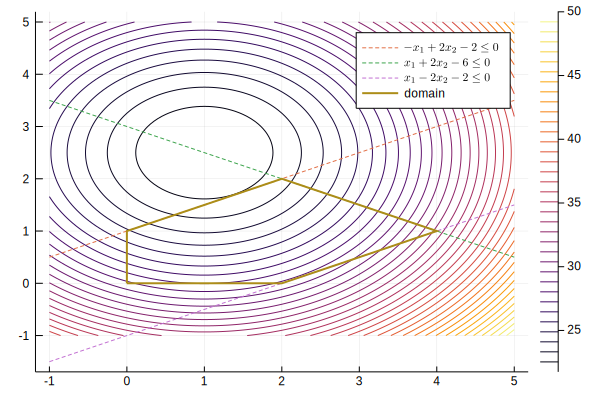

In [130]:
using Plots
using LaTeXStrings

Q = Float64[2 0
     0 2]
c = Float64[2, 5]
A = Float64[-1  2
      1  2
      1 -2
     -1  0
      0 -1]
b = Float64[2, 6, 2, 0, 0]

x = -1:0.05:5
y = -1:0.05:5
z = Surface((x,y)->(0.5 .* [x y]*Q*[x;y] .- transpose(c)*[x;y] .+ 0.5 .* transpose(c)*Q*c)[1], x, y)
contour(x, y, z, levels=35)
plot!(x, (2 .+ x) ./ 2, linestyle=:dash, label=L"-x_1+2x_2-2\le 0")
plot!(x, (6 .- x) ./ 2, linestyle=:dash, label=L"x_1+2x_2-6\le 0")
plot!(x, (2 .- x) ./ -2, linestyle=:dash, label=L"x_1-2x_2-2\le 0")
plot!([0,2,4,2,0,0],[0,0,1,2,1,0], linewidth=2, label="domain")

We refer the constraints, in order, by indices $1$ through $5$.
For this problem it is easy to determine a feasible initial point;
say $\vec{x}^{\left(0\right)}=\begin{pmatrix}2 & 0\end{pmatrix}\mathsf{T}$.
Constraints $3$ and $5$ are active at this point, and we set $W_{0}=\left\{ 3,5\right\} $.
Note that we could just as validly have chosen $W_{0}=\left\{ 5\right\} $
or $W_{0}=\left\{ 3\right\} $ or even $W_{0}=\emptyset$; each choice
would lead the algorithm to perform somewhat differently.

In [90]:
x = [2, 0]
g = Q*x - c
ain = [reshape(A[3,:], 1, 2); reshape(A[5,:], 1, 2)]
sol = [Q transpose(ain)
       ain zeros(2,2)] \ [-g; 0; 0]

4-element Array{Float64,1}:
  6.661338147750939e-16
  4.440892098500626e-16
 -2.0000000000000013   
 -0.9999999999999967   

Since $\vec{x}^{\left(0\right)}$ lies on a vertex of the feasible
region, it is obviously a minimizer of the objective function $f$
with respect to the working set $W_{0}$; that is, the solution of
the subproblem with $k=0$ is $\vec{d}^{\left(0\right)}=\vec{0}$.
We can then find the multipliers $\mu_{3}^{\circ}$ and $\mu_{5}^{\circ}$
associated with the active constraints. Substitution of the data from
our problem yields
\begin{equation}
\begin{pmatrix}-1\\
2
\end{pmatrix}\lambda_{3}^{\circ}+\begin{pmatrix}0\\
1
\end{pmatrix}\lambda_{5}^{\circ}=\begin{pmatrix}2\\
-5
\end{pmatrix}\,,
\end{equation}
which has solution $\lambda_{3}^{\circ}=-2$ and $\lambda_{5}^{\circ}=-1$. 

We now remove constraint $3$ from the working set, because it has
the most negative multiplier, and set $W_{1}=\{5\}$.

In [102]:
x = [2, 0]
g = Q*x - c
ain = reshape(A[5,:], 1, 2)
sol = [Q transpose(ain)
       ain zeros(1,1)] \ [-g; 0]

3-element Array{Float64,1}:
 -1.0
  0.0
 -5.0

We begin iteration $1$ by finding the solution of the subproblem for $k=1$, which is
$\vec{d}^{\left(1\right)}= \begin{pmatrix}-1 & 0\end{pmatrix}^\mathsf{T}$.

In [103]:
d = sol[1:2]
α = min(1.0, [(reshape(A[j,:], 1, 2) * d)[1,1] ≤ 0 ? 1.0 : ((b[j] .- reshape(A[j,:], 1, 2) * x) / (reshape(A[j,:], 1, 2) * d))[1,1] for j in (1,2,3,4)]...)

1.0

The step-length formula yields $\alpha_{1}=1$, and the new iterate
is $\vec{x}^{\left(2\right)}=\begin{pmatrix}1 & 0\end{pmatrix}^\mathsf{T}$. There are no blocking constraints, so that $W_{2}=W_{1}=\left\{ 5\right\} $

In [104]:
x = x + α .* d
g = Q*x - c
ain = reshape(A[5,:], 1, 2)
sol = [Q transpose(ain)
       ain zeros(1,1)] \ [-g; 0]

3-element Array{Float64,1}:
  0.0
  0.0
 -5.0

We find at the start of iteration $2$ that the solution of the
subproblem is $\vec{d}^{\left(2\right)}=\vec{0}$. We deduce that
the Lagrange multiplier for the lone working constraint is $\lambda_{5}^{\circ}=-5$,
so we drop the working set to obtain $W_{3}=\emptyset$.

In [105]:
g = Q*x - c
sol = Q \ (-g)

2-element Array{Float64,1}:
 -0.0
  2.5

Iteration $3$ starts by solving the unconstrained problem, to obtain
the solution $\vec{d}^{\left(3\right)}=\begin{pmatrix}0 & 2.5\end{pmatrix}^\mathsf{T}$.

In [106]:
d = sol[1:2]
α = min(1.0, [(reshape(A[j,:], 1, 2) * d)[1,1] ≤ 0 ? 1.0 : ((b[j] .- reshape(A[j,:], 1, 2) * x) / (reshape(A[j,:], 1, 2) * d))[1,1] for j in (1,2,3,4,5)]...)

0.6000000000000001

The step-length formula yields a step length of $\alpha_{3}=0.6$
and a new iterate $\vec{x}^{\left(4\right)}=\begin{pmatrix}1 & 1.5\end{pmatrix}^\mathsf{T}$. There
is a single blocking constraint (constraint $1$), so we obtain $W_{4}=\left\{ 1\right\} $.

In [107]:
x = x + α .* d
g = Q*x - c
ain = reshape(A[1,:], 1, 2)
sol = [Q transpose(ain)
       ain zeros(1,1)] \ [-g; 0]

3-element Array{Float64,1}:
 0.3999999999999999 
 0.19999999999999996
 0.7999999999999998 

The solution of the subproblem for $k=4$ is then $\vec{d}^{\left(4\right)}=\begin{pmatrix}0.4 & 0.2\end{pmatrix}^\mathsf{T}$.

In [108]:
d = sol[1:2]
α = min(1.0, [(reshape(A[j,:], 1, 2) * d)[1,1] ≤ 0 ? 1.0 : ((b[j] .- reshape(A[j,:], 1, 2) * x) / (reshape(A[j,:], 1, 2) * d))[1,1] for j in (1,2,3,4,5)]...)

1.0

The new step-length is $1$. There are no blocking constraints
on this step, so the next working set in unchanged: $W_{5}=\left\{ 1\right\} $. The new iterate is $\vec{x}^{\left(5\right)}=\begin{pmatrix}1.4 & 1.7\end{pmatrix}^\mathsf{T}$.

In [109]:
x = x + α .* d
g = Q*x - c
ain = reshape(A[1,:], 1, 2)
sol = [Q transpose(ain)
       ain zeros(1,1)] \ [-g; 0]

3-element Array{Float64,1}:
 0.0               
 0.0               
 0.7999999999999998

Finally, we solve the subproblem for $k=5$ to obtain a solution $\vec{d}^{\left(5\right)}=\vec{0}$.
We find a multiplier $\mu_{1}^{\circ}=0.8$, so we have found the
solution. Wet set $\vec{x}^{\star}=\begin{pmatrix}1.4 & 1.7\end{pmatrix}^\mathsf{T}$
and terminate.

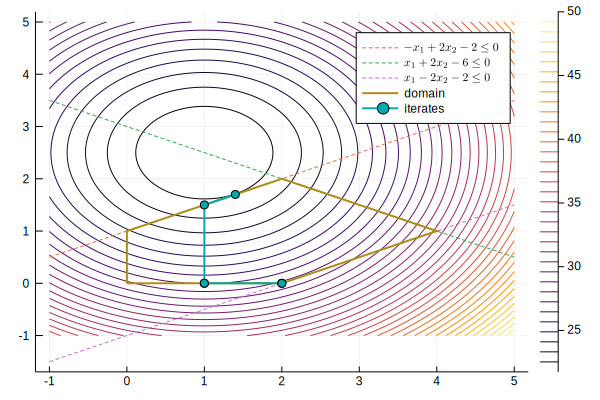

In [129]:
x = -1:0.05:5
y = -1:0.05:5
z = Surface((x,y)->(0.5 .* [x y]*Q*[x;y] .- transpose(c)*[x;y] .+ 0.5 .* transpose(c)*Q*c)[1], x, y)
contour(x, y, z, levels=35)
plot!(x, (2 .+ x) ./ 2, linestyle=:dash, label=L"-x_1+2x_2-2\le 0")
plot!(x, (6 .- x) ./ 2, linestyle=:dash, label=L"x_1+2x_2-6\le 0")
plot!(x, (2 .- x) ./ -2, linestyle=:dash, label=L"x_1-2x_2-2\le 0")
plot!([0,2,4,2,0,0],[0,0,1,2,1,0], linewidth=2, label="domain")
plot!([2,2,1,1,1,1.4], [0,0,0,0,1.5,1.7], linewidth=2, label="iterates", markershape=:circle)

## Sequential Quadratic Programming

We consider the general constrained problem
\begin{align*}
\min\, & f\left(\vec{x}\right)\\
\textrm{subject to} & \begin{cases}
\vec{h}\left(\vec{x}\right)=\vec{0}\\
\vec{g}\left(\vec{x}\right)\leq\vec{0}
\end{cases}
\end{align*}
where $f:\mathbb{R}^{n}\rightarrow\mathbb{R}$, $\vec{h}:\mathbb{R}^{n}\rightarrow\mathbb{R}^{m}$,
$m\leq n$, and $\vec{g}:\mathbb{R}^{n}\rightarrow\mathbb{R}^{p}$. The idea
behind the _sequential quadratic programming_ (SQP) approach
is to model the general problem at the current iterate $\vec{x}^{\left(k\right)}$
by a quadratic programming subproblem, then use the minimizer of this
subproblem to define a new iterate $\vec{x}^{\left(k+1\right)}$.
The challenge is to design the quadratic subproblem so that it yields
a good step for the general optimization problem.

We know that the extended Lagrangian function for this problem is

\begin{equation}
\mathcal{L}\left(\vec{x},\vec{\lambda},\vec{\mu}\right)=f\left(\vec{x}\right)+\vec{\lambda}^\mathsf{T}\vec{h}\left(\vec{x}\right)+\vec{\mu}^\mathsf{T}\vec g\left(\vec{x}\right)\,.
\end{equation}

Applying Newton's method to the Lagrangian function and linearizing
both the equality and the inequality constraints yields the following
subproblem 
\begin{align*}
\min_{\vec{d}^{\left(k\right)}}\, & \frac{1}{2}\left(\vec{d}^{\left(k\right)}\right)^\mathsf{T} \mathsf{H} \mathcal{L}\left(\vec{x}^{\left(k\right)},\vec{\lambda}^{\left(k\right)},\vec{\mu}^{\left(k\right)}\right)\vec{d}^{\left(k\right)}+ \mathsf{D} \mathcal{L}\left(\vec{x}^{\left(k\right)},\vec{\lambda}^{\left(k\right)},\vec{\mu}^{\left(k\right)}\right)\vec{d}^{\left(k\right)}\\
\textrm{subject to}\, & \begin{cases}
 \mathsf{J}\vec{h}\left(\vec{x}^{\left(k\right)}\right)\vec{d}^{\left(k\right)}=-\vec{h}\left(\vec{x}^{\left(k\right)}\right)\\
 \mathsf{D} g_{j}\left(\vec{x}^{\left(k\right)}\right)\vec{d}^{\left(k\right)}=-g_{j}\left(\vec{x}^{\left(k\right)}\right)\,, & j\in W_{k}\,,
\end{cases}
\end{align*}

where $\mu_{j}^{\left(k\right)}=0$, for all
$j\notin W_{k}$. We can use the active-set method for quadratic programming
to solve this subproblem. The new iterate is given by $\vec{x}^{\left(k+1\right)}$,
$\vec{\lambda}^{\left(k+1\right)}$, $\vec{\mu}^{\left(k+1\right)}$
and $W_{k+1}$.

If the SQP method is able to identify the optimal active set then
it will act like a Newton method for equality-constrained optimization
and will converge rapidly.

It is also remarkable that, far from the solution, the SQP approach
is usually able to improve the estimate of the active set and guide
the iterates towards a solution.

Non-quadratic objective functions, however, can impede progress of
the SQP algorithm, a phenomenon known as the Maratos effect. Steps
that make good progress toward a solution are rejected and the algorithm
fails to converge rapidly. These difficulties can be overcome by means
of a _second-order correction_.